#imports

In [ ]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

2.0.1+cu118


#Basic components

Create Word Embeddings


In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

#Positional Encoding

In "attention is all you need paper" author used the following functions to create positional encoding. On odd time steps a cosine function is used and in even time steps a sine function is used.

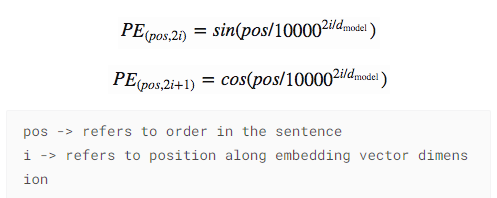



In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """

        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x


#Self Attention
**Step 1**: The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. Each of the vector will be of dimension 1x64.
Since we have a multihead attention we will have 8 self attention heads.I will explain the code with 8 attention head in mind.

###How key,queries and values can be created?
We will have a key matrix,query matrix and a value matrix to generate key, query and value. These matrixes are learned during training.

**Step 2**: Second step is to calculate the score. ie, we will multiply query marix with key matrix. [Q x K.t]

**Step 3**: Now divide the output matrix with square root of dimension of key matrix and then apply Softmax over it.

**Step 4**: Then this gets multiply it with value matrix.

**Step 5**: Once we have this we will pass this through a linear layer. This forms the output of multihead attention.



In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim)

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        seq_length_query = query.size(1)

        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)

        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)


        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)

        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64)

        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)

        output = self.out(concat) #(32,10,512) -> (32,10,512)

        return output


#**Encoder**

**Step 1**: First input(padded tokens corresponding to the sentence) get passes through embedding layer and positional encoding layer.

**Step 2**: As discussed above it will passed through the multihead attention layer and creates useful representational matrix as output.

**Step 3**: Next we have a normalization and residual connection. The output from multihead attention is added with its input and then normalized.

**Step 4**: Next we have a feed forward layer and a then normalization layer with residual connection from input(input of feed forward layer) where we passes the output after normalization though it and finally gets the output of encoder.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):

        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block

        """

        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out



class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention

    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])

    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

#**Decoder**

**Step 1:**First the output gets passed through the embeddin and positional encoding to create a embedding vector of dimension 1x512 corresponding to each word in the target sequence.

**Step 2:**The embeddig output gets passed through a multihead attention layers as before(creating key,query and value matrixes from the target input) and produces an output vector. This time the major difference is that we uses a mask with multihead attention.

**Step 3**:As before we have a add and norm layer where we add with output of embedding with attention out and normalized it.

**Step 4**:Next we have another multihead attention and then a add and norm layer. This multihead attention is called encoder-decorder multihead attention. For this multihead attention we create we create key and value vectors from the encoder output. Query is created from the output of previous decoder layer.

**Step 5**: Next we have a feed forward layer(linear layer) with add and nom which is similar to that of present in the encoder.

**Step 6**: Finally we create a linear layer with length equal to number of words in total target corpus and a softmax function with it to get probablity of each word.



In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=16):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)


    def forward(self, key, query, x,mask):

        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention
        Returns:
           out: output of transformer block

        """

        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))

        out = self.transformer_block(key, query, value)


        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8)
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):

        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """


        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        out = F.softmax(self.fc_out(x))

        return out

#**Transformer Class**
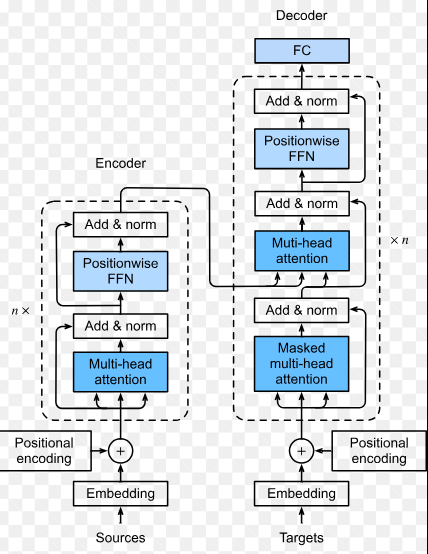

In [ ]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()

        """
        Args:
           embed_dim:  dimension of embedding
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """

        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)


    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]

            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)


        return out_labels

    def forward(self, src, trg):
        """
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)

        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

#**Testing Our code**

In [ ]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1],
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1],
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
model

torch.Size([2, 12]) torch.Size([2, 12])


Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [ ]:
out = model(src, target)
out.shape

torch.Size([2, 12, 11])

In [ ]:
# inference

model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)



src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])
trg = torch.tensor([[0]])
print(src.shape,trg.shape)
out = model.decode(src, trg)
out

torch.Size([1, 12]) torch.Size([1, 1])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]